# Chapter 3 - Linear Regression

*Курсив*- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [36]:
# This code is quoted from
# https://github.com/JWarmenhoven/ISLR-python

In [37]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
# ML libraries
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [38]:
advertising = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Advertising.csv', usecols=[1,2,3,4])
advertising.head(3)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3


In [39]:
credit = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0


In [40]:
auto = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/schulich_data_science_1/master/Data/Auto.csv', na_values='?').dropna()
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite


## 3.1 Simple Linear Regression

### Figure 3.1 - Least squares fit

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


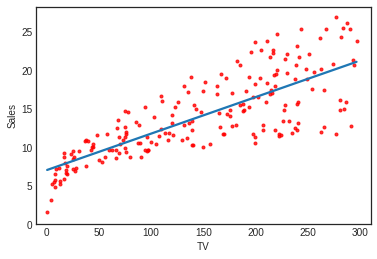

In [41]:
sns.regplot(advertising.TV, advertising.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [42]:
X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1) 
y = advertising.Sales
np.mean(X), np.std(X)

(1.0089706847793422e-14, 85.63933175679269)

In [43]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()
regr.fit(X,y)
regr.intercept_, regr.coef_

(14.0225, array([0.04753664]))

In [44]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)

xx, yy = np.meshgrid(B0, B1, indexing='xy')

Z = np.zeros((B0.size,B1.size))
# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'  # S, What is it?
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

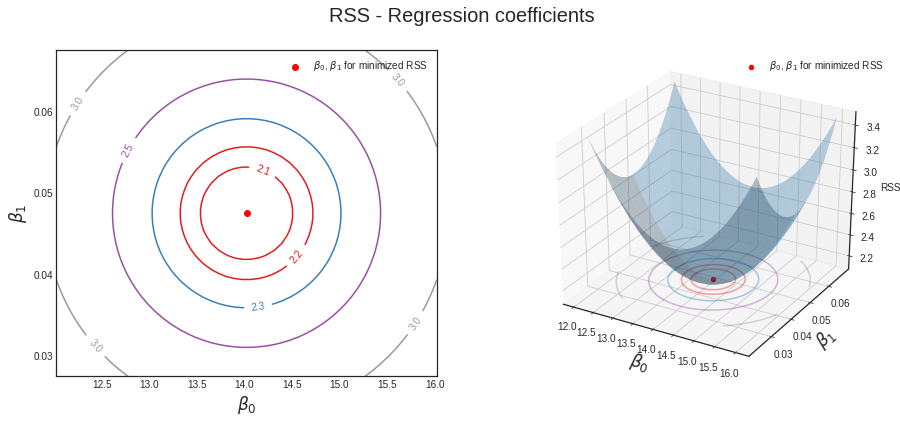

In [45]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

# 1 line
# 2 columns
# 1 or 2 column used for axes
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
# we will use the approximated Z for those levels
# cmap is a sequence of colors
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
# The scatter is plotted for a single point of center
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
# again scatter for a single point of a minimum
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels 

In [46]:
est = smf.ols('Sales ~ TV', advertising).fit()
print(est.summary()) # S
print("\n -----------est.summary().tables[1]:-----") # B
est.summary().tables[1]

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           1.47e-42
Time:                        19:56:34   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [47]:
# RSS with regression coefficients
((advertising.Sales - (est.params[0] + est.params[1]*advertising.TV))**2).sum()/1000

2.102530583131351

### Table 3.1 & 3.2 - Scikit-learn

In [48]:
regr = skl_lm.LinearRegression()

X = advertising.TV.values.reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
regr.intercept_, regr.coef_

(7.032593549127695, array([0.04753664]))

In [49]:
Sales_pred = regr.predict(X)
r2_score(y, Sales_pred)

0.611875050850071